# hierarchical clustering from scratch

Now that we have a list of pixels we want to know which are contained in the same star, which are pure noise etc. That is where hierarchical clustering comes to the rescue !

https://en.wikipedia.org/wiki/Dendrogram

https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec



<div>
<img  src="../images/forest.png" width="900"/>
</div>
http://pixelartmaker.com/art/bee8c366032e967.png


In [333]:
class IndexCluster(object):
    
    def __init__(self, matrix, index=None):
        self.matrix = matrix
        #self.clusters = list()
        self.indexes = list()
        self.node = anytree.Node('')
        # initialize the cluster with one index
        if index is not None:
            self.indexes.append(index)
            #self.clusters.append(index)
            self.node.name = str(index)
        
    def append(self, cluster):
        if not isinstance(cluster, IndexCluster):
            raise TypeError('must be a cluster')
        #self.clusters.append(list(cluster.clusters))
        for index in cluster.indexes:
            if index in self.indexes:
                raise ValueError('at least one index of the appended cluster is already in the cluster')
        self.indexes += cluster.indexes
        if hasattr(self, 'submatrix'): del self.submatrix
        cluster.node.parent = self.node
        
    def get_min_dist(self, cluster):
        if not hasattr(self, 'submatrix'):
            # reconstruct the submatrix from the indexes of the cluster
            self.submatrix = np.min(self.matrix[:, self.indexes], axis=1)
        return np.min(self.submatrix[cluster.indexes])
    
    def show_as_text(self):
        for pre, fill, node in anytree.RenderTree(self.node):
            print("%s%s" % (pre, node.name))
    

class HCPixelClassificator(object):
    
    def __init__(self, x, y, v):
        self.pixels = pandas.DataFrame()
        self.pixels['x'] = x
        self.pixels['y'] = y
        self.pixels['v'] = v
    
        self.matrix = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(np.array([x, y]).T))
        
    def run(self):
        clusters = list()
        # start to iterate through a list of single-element clusters
        for i in range(len(self.pixels)):
            clusters.append(IndexCluster(self.matrix, index=i))
        
        while len(clusters) > 1:
            
            indexes = list(range(len(clusters)))
            new_clusters = list()
            while len(clusters) > 0:
                #print(len(clusters))
                new_cluster = IndexCluster(self.matrix)
                icluster = clusters.pop(0)
                indexes.pop(0)
                new_cluster.append(icluster) # start with the first cluster of the list
                #distances = matrix[:,icluster.indexes][indexes]
                distances = np.array([icluster.get_min_dist(iclu) for iclu in clusters])
                if len(distances) == 0: break
                nearest_indexes = np.nonzero(distances == np.min(distances))[0]
                
                nearest_indexes = np.sort(nearest_indexes)
                for i in nearest_indexes:
                    new_cluster.append(clusters.pop(i))
                    indexes.pop(i)
                    # be careful for each time an item is popped out the indexes of all the following items are reduced by 1
                    # as the nearest_indexes list is ordered we can just subtract 1 to all the list
                    nearest_indexes -= 1 
                    
                new_clusters.append(new_cluster)
            print(len(new_clusters), 'end-----')
            clusters = new_clusters
        return clusters[0]
    
        
            

hcpc = HCPixelClassificator(pixcoords[0], pixcoords[1], im[pixcoords])
clusters = hcpc.run()

KeyboardInterrupt: 

### use anytree
https://github.com/c0fec0de/anytree

    

1389


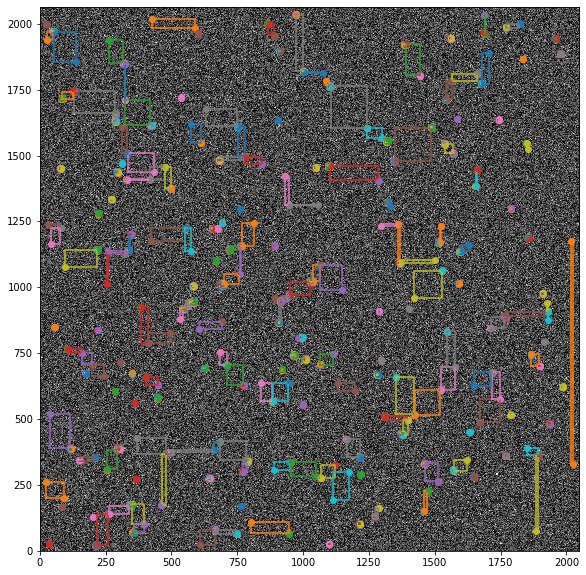

In [317]:



def show_layer(index, hcpc, clust, im, c=None):
    pl.figure(figsize=(10,10))
    pl.imshow(im.T, vmin=np.percentile(im, 5), vmax=np.percentile(im, 99.9), cmap='gray', origin='bottom-left')
    
    node = clust.node
    desc = node.descendants
    layer = list()
    for idesc in desc:
        if idesc.depth == index:
            layer.append(idesc)
    print(len(layer))
            
    for inode in layer:
        leaves = [int(leaf.name) for leaf in inode.leaves]        
        allx = hcpc.pixels['x'].values[leaves]
        ally = hcpc.pixels['y'].values[leaves]
    
        xmin, xmax, ymin, ymax = np.min(allx), np.max(allx), np.min(ally), np.max(ally)
        pl.plot((xmin, xmax, xmax, xmin, xmin), 
                (ymin, ymin, ymax, ymax, ymin), 
                c=c)
        pl.scatter(allx, ally)
            
show_layer(9, hcpc, clusters, im)